In [1]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
import emcee
from scipy.special import erfc
from lmfit.models import SkewedGaussianModel
%matplotlib inline

In [2]:
filename = 'run562.txt'
infile = open(filename,'r')

xvals2=[];ymeas2=[]
while True:
    line = infile.readline()
    if not line: break
        
    items = line.split()
    xvals2.append(float(items[0]))
    ymeas2.append(float(items[1]))

infile.close()

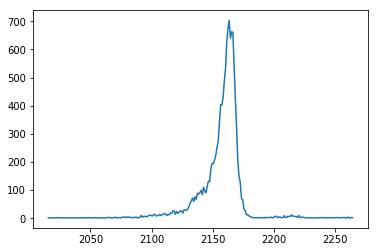

In [3]:
pl.subplot(111)
pl.plot(xvals,ymeas)
pl.show()

---

https://lmfit.github.io/lmfit-py/builtin_models.html#skewedgaussianmodel

In [4]:
'''
def gauss_fn(p0, x):
    
    amp,mu,sigma,gamma = p0
    model = SkewedGaussianModel()
        #amp*=sigma*np.sqrt(2*np.pi)
    
    # set initial parameter values
    params = model.make_params(amplitude=amp, center=mu, sigma=sigma, gamma=gamma)
    ymod = model.eval(params=params,x=x)
    
    return ymod
'''

def gf3(p0, x):
    #this is the fuctional form that we have been using in our manual fit
    #it is the sum of a gaussian and a skewed gaussian with the same mean
    #the extra parameters r and beta are introduced
    #r is the fraction of the height of the skewed gaussian given as a pecentage
    #beta is the 'skewneess' of the second skew gaussian
    #it is the decay constant of an exponential tail on the skewed gaussian
    #this exponential tail is convolved with a gaussian resolution function
    
    amp, mu, sigma, r, beta = p0
    
    
    #gaussian part
    ygaus = amp * (1 - r/100) * np.exp((-(x - mu)**2)/(2 * sigma**2))
    
    #'skew' gaussian part. erfc is 1 - the error function
    yskew = amp * (r/100) * np.exp((x-mu)/beta) * erfc( (x-mu)/(sigma * np.sqrt(2))  + sigma/(beta*np.sqrt(2)))
    #yskew = 0
    #ygaus = 0
    ymod = yskew + ygaus
    
    return ymod

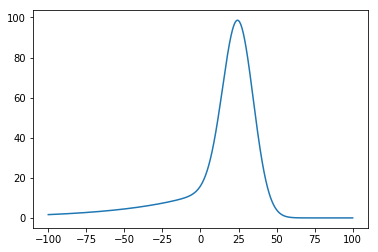

In [5]:
#test to see if this function looks correct
x = np.arange(-100, 100, step = 0.001)
y = gf3([100, 25, 10, 10,50],x)

#y = np.exp(((x-5)/5)) * erfc(((x-5)/(10*2**0.5)) + 2/(5*2**0.5 ))
pl.plot(x,y)

pl.show()

In [6]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    #ymod = gauss_fn(p0,x)
    ymod = gf3(p0,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

In [7]:
# use maxvalue to guess amplitude:
a0 = np.max(ymeas)

# use position of maxvalue to guess mean:
m0 = xvals[np.argmax(ymeas)]

# just guess width:
s0 = 10.

# just guess r and beta from what they usually turn out about from experience
r0 = 10.
b0 = 5.

# adjust the amplitude for the normalisation factor:
#a0*=s0*np.sqrt(2*np.pi)

print(a0,m0,s0,r0,b0)
p0 = np.array([a0,m0,s0,r0,b0])

704.0 2163.5 10.0 10.0 5.0


In [8]:
bnds = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))

print(len(p0))
print(len(bnds))

5
5


In [9]:
nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]

In [10]:
print(p1)

[ 717.00898068 2164.43769642    4.71246332   29.54070326   15.49040933]


-309.9316640252073


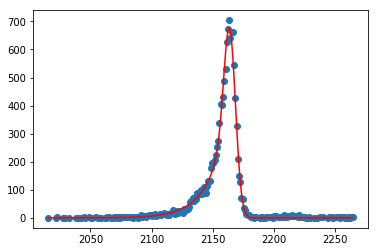

In [11]:
yfit = gf3(p1,xvals)

fig = pl.figure(1)

ax = fig.add_subplot(111)

ax.scatter(xvals,ymeas)
ax.plot(xvals,yfit,c='r')

fig.savefig("gf3fit.png")

print(lnlike(p1, xvals, ymeas))

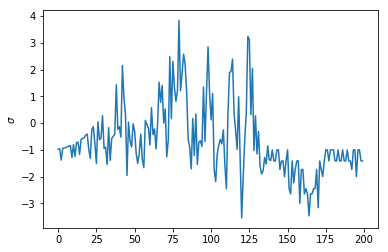

In [12]:
res = (yfit - ymeas)/np.sqrt(ymeas)
fig = pl.figure(1)
ax = fig.add_subplot(111)
pl.plot(res)
pl.ylabel(r"$\sigma$")
fig.savefig("residuals.png")

These residuals still look weird.

---

In [13]:
ndim, nwalkers = 5, 500
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [14]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(xvals, ymeas))

In [15]:
p0 = sampler.run_mcmc(pos, 100) #this doesn't work with 500 as it tries to use a negative value of r

In [16]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
print(samples.shape)

(25000, 5)


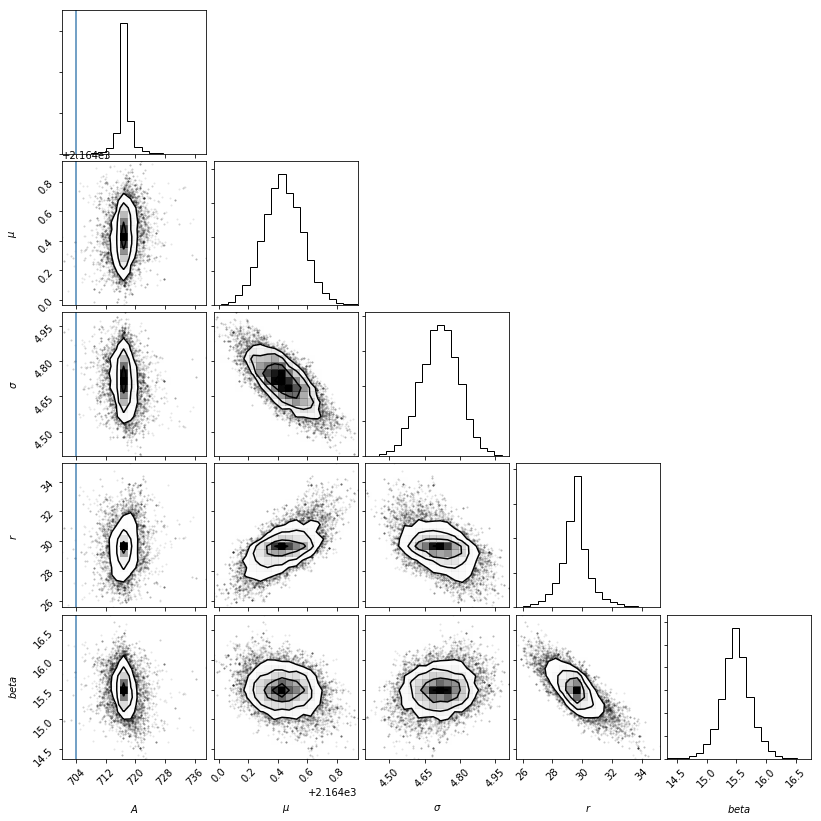

In [17]:
import corner

fig = corner.corner(samples, labels=["$A$", "$\mu$", "$\sigma$","$r$", "$beta$"],
                      truths=[a0, m0, s0, r0, b0])
fig.savefig("triangle.png")

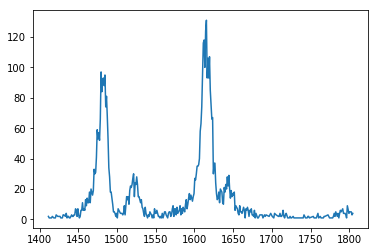

In [18]:
#now do it with a multiplet
xvals = np.array(xvals2[1300:1650])
ymeas = np.array(ymeas2[1300:1650])

pl.plot(xvals,ymeas)
pl.show()

In [19]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    npeaks = int((len(p0)-3)/2)
    ymod = 0
    for i in range(npeaks):
        p1 = [p0[i * 2], p0[i * 2 + 1], p0[-3], p0[-2], p0[-1]]
        ymod += gf3(p1,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

In [20]:
bnd = ((0,None), (None,None), )
metabnd = ((0.1,10), (0.1, 100), (0.1,None))
#bnds2 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))
#bnds3 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))
#bnds4 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))

bnds = []

for peak in range(5):
    for bound in bnd:
        bnds.append(bound)

for bound in metabnd:
    bnds.append(bound)
        
bnds
#len(p0) == len(bnds)



[(0, None),
 (None, None),
 (0, None),
 (None, None),
 (0, None),
 (None, None),
 (0, None),
 (None, None),
 (0, None),
 (None, None),
 (0.1, 10),
 (0.1, 100),
 (0.1, None)]

In [21]:
mu1 = 1485
A1 = np.max(ymeas[int(np.where(xvals == mu1 + 0.5)[0]) - 5 : int(np.where(xvals == mu1 + 0.5)[0]) + 5 ])

mu2 = 1520
A2 = np.max(ymeas[int(np.where(xvals == mu2 + 0.5)[0]) - 5 : int(np.where(xvals == mu2 + 0.5)[0]) + 5 ])

mu3 = 1620
A3 = np.max(ymeas[int(np.where(xvals == mu3 + 0.5)[0]) - 5 : int(np.where(xvals == mu3 + 0.5)[0]) + 5 ])

mu4 = 1650
A4 = np.max(ymeas[int(np.where(xvals == mu4 + 0.5)[0]) - 5 : int(np.where(xvals == mu4 + 0.5)[0]) + 5 ])

mu5 = 1670
A5 = np.max(ymeas[int(np.where(xvals == mu5 + 0.5)[0]) - 5 : int(np.where(xvals == mu5 + 0.5)[0]) + 5 ])

sig = 2
r = 30
b = 15

g1 = [A1,mu1]
g2 = [A2,mu2]
g3 = [A3,mu3]
g4 = [A4,mu4]
g5 = [A5,mu5]

mets = [sig,r,b]

p0 = []

for peak in [g1,g2,g3,g4,g5,mets]:
    for parameter in peak:
        p0.append(parameter)



A1

95.0

In [22]:
result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]

[  85.10749076 1481.88414693   24.98915458 1522.84587993  117.73644069
 1615.88485026   24.26932138 1643.85760704    6.16783883 1670.00794883
    6.297685     11.50724761   22.54110689]


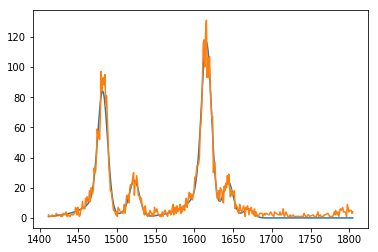

In [23]:
print(p1)

npeaks = int((len(p1) - 3)/2)
npeaks
ymod = 0
for i in range(npeaks):
    p2 = [p1[i * 2], p1[i * 2 + 1], p1[-3], p1[-2], p1[-1]]
    #print(p2)
    ymod += gf3(p2,xvals)

ymodinit = 0    
for i in range(npeaks):
    p3 = [p0[i * 2], p0[i * 2 + 1], p0[-3], p0[-2], p0[-1]]
    #print(p2)
    ymodinit += gf3(p3,xvals)
    
#thing = 
pl.plot(xvals, ymod)
#pl.plot(xvals, ymodinit)
pl.plot(xvals,ymeas)
pl.show()


In [24]:
#this is why we fix the relative widths